In [16]:
import plotly.graph_objects as go
import networkx as nx

# reading input log file

test_name = "vist"

stat_path=f"example_stat/{test_name}"
image_path=f"{stat_path}/images"

In [17]:
# My utility functions
import utils.stat_loader as sload
import utils.stat_print as sp
import utils.vfd_stat2graph as vfd2g
import utils.vfd_graph2sankey as vfd2sk

# Improve Functions
## TODO
- Add dataset nodes
- Add file address ordering nodes


In [18]:
STAGE_START = 0
STAGE_END = 10


TASK_ORDER_LIST = sload.load_task_order_list(stat_path)
STAGE_END = sload.correct_end_stage(TASK_ORDER_LIST, STAGE_END)

TASK_ORDER_LIST = sload.current_task_order_list(TASK_ORDER_LIST, STAGE_START, STAGE_END)

TASK_LISTS = list(TASK_ORDER_LIST.keys())

print(f"TASK_ORDER_LIST = {TASK_ORDER_LIST}")
TASK_LISTS


STAGE_END is not in TASK_ORDER_LIST, set to max order: 1
TASK_ORDER_LIST = {'arldm_saveh5': 0, 'arldm_train': 1}


['arldm_saveh5', 'arldm_train']

In [19]:
vfd_files = sload.find_files_with_pattern(stat_path, "vfd")
# vfd_files = vfd_files[0:1]
print(vfd_files)

vfd_dict = sload.load_stat_json(vfd_files)
# print(vfd_dict)

print("loading yaml done")

['example_stat/vist/271485-vfd_data_stat.json', 'example_stat/vist/271491-vfd_data_stat.json']
loading example_stat/vist/271485-vfd_data_stat.json
loading example_stat/vist/271491-vfd_data_stat.json
loading yaml done


In [20]:
# Show VFD Tracker overhead
sp.show_all_overhead("VFD", vfd_dict)

Total VFD overhead: 44.0 ms
Total POSIX IO time: 177.0 ms


In [21]:
import os
from scipy.stats import rankdata 

def add_file_address_nodes(G, stat_dict, task_list):
    pass

def dset_page_map(cur_datasets, page_size=65536):
    dataset_page_map = {}
    for dset, stat in cur_datasets.items():
        dset_pages = []
        for type in stat['metadata']:
            mem_type_stat = stat['metadata'][type]
            write_ranges = mem_type_stat['write_ranges']
            read_ranges = mem_type_stat['read_ranges']
            for acc_range in write_ranges.values():
                #split tuple and store in list
                dset_pages.append(int(acc_range[0]))
                dset_pages.append(int(acc_range[1]))
            for acc_range in read_ranges.values():
                #split tuple and store in list
                dset_pages.append(int(acc_range[0]))
                dset_pages.append(int(acc_range[1]))
        dataset_page_map[dset] = dset_pages
    
    return dataset_page_map
    
def add_page_nodes(all_dataset_page_map):
    # all values in one list
    all_dset_pages = []
    for pages in all_dataset_page_map.values():
        all_dset_pages.extend(pages)
    
    min_page = min(all_dset_pages)
    max_page = max(all_dset_pages)
    # split pages into 4 groups
    page_range = max_page - min_page
    page_group = page_range // 4
    # plit pages into 4 nodes
    page_nodes_attr = {}
    
    for i in range(4):
        # page_bottom = (min_page + page_group * i) * page_size 
        # page_max = (min_page + page_group * (i+1)) * page_size -1
        page_bottom = (min_page + page_group * i)
        page_max = (min_page + page_group * (i+1))
        # page_nodes.append(min_page + page_group * i)
        page_node = f"[{page_bottom}-{page_max})"
        # x position to 0, y position to i
        page_nodes_attr[page_node] = {'pos': (0, i), 'rpos':0 } 
    
    # print(f"page_nodes_attr: {page_nodes_attr}")

def get_all_dset_stat(cur_datasets, metadata_access, data_access):
    
    dset_stat_dict = {}
    dset_order = {}
    
    # enumerate all datasets
    for i in range(len(cur_datasets)): # TODO: assume json order is preserved
        dset = cur_datasets[i]

        # fix unknown dataset
        if dset == "unknown" and len(data_access[dset]) == 0:
            dset = "file"
            
        if dset not in dset_stat_dict:
            dset_stat_dict[dset] = {}
        dset_stat_dict[dset]['metadata'] = metadata_access[dset]
        dset_stat_dict[dset]['data'] = data_access[dset]
        # get all read_ranges and write_ranges keys to int
        all_io_idx = []
        for type in dset_stat_dict[dset]['metadata']:
            read_io_idx = dset_stat_dict[dset]['metadata'][type]['read_ranges'].keys()
            write_io_idx = dset_stat_dict[dset]['metadata'][type]['write_ranges'].keys()
            # convert to int
            read_io_idx = [int(i) for i in read_io_idx]
            write_io_idx = [int(i) for i in write_io_idx]
            all_io_idx.extend(read_io_idx)
            all_io_idx.extend(write_io_idx)

        for type in dset_stat_dict[dset]['data']:
            read_io_idx = dset_stat_dict[dset]['data'][type]['read_ranges'].keys()
            write_io_idx = dset_stat_dict[dset]['data'][type]['write_ranges'].keys()
            # convert to int
            read_io_idx = [int(i) for i in read_io_idx]
            write_io_idx = [int(i) for i in write_io_idx]
            all_io_idx.extend(read_io_idx)
            all_io_idx.extend(write_io_idx)
        
        
        # find the minimum in all_io_idx
        min_io_idx = min(all_io_idx)
        dset_order[dset] = min_io_idx
        
    dset_order = dict(zip(dset_order.keys(), rankdata([-i for i in dset_order.values()], method='min')))
    # print(f"dset_order: {dset_order}")
    for dset, order in dset_order.items():
        dset_stat_dict[dset]['order'] = order
    
    return dset_stat_dict

def add_task_dset_file_nodes(G, stat_dict, task_list):
    node_order_list = {} # keeptrack of dataset order in each file
    file_page_map = {} # keep track of dataset page map in each file
    edge_stats = {} # All edge stats
    layer = 0
    for stat_file, stat_list in stat_dict.items():
        print(f"stat_file: {stat_file}")
        for li in stat_dict[stat_file]:
            k = list(li.keys())[0]
            if 'file' in k: # look for file entries
                stat = li[k]
                parts = k.split("-")
                node_order = int(parts[1])
                if node_order not in node_order_list:
                    node_order_list[node_order] = 0
                
                task_name = stat['task_name']
                # Extract taskname without PID: e.g. arldm_saveh5-1119693 tp arldm_saveh5
                task_name_base = task_name.split('-')[0]
                
                if task_name_base in task_list: # select task entries
                    parts = k.split("-")
                    node_name = f"{k} : {li[k]['file_name']}"
                    access_type = stat['access_type']
                    # file_name = stat['file_name']
                    file_name = os.path.basename(stat['file_name']) # FIXME: use basename for now
                    node_order = int(parts[1])
                    
                    
                    file_stat = {"open_time": stat['open_time'], "close_time": stat['close_time'], 
                                 "file_intent": stat['file_intent'], 
                                 "file_read_cnt": stat['file_read_cnt'], 
                                 "file_write_cnt": stat['file_write_cnt'], 
                                 "access_type": stat['access_type'], "io_bytes": stat['io_bytes'], 
                                 "file_size": stat['file_size']}
                    
                    # Get dataset page map and save to file_page_map
                    # print(f"file_name: {file_name}")
                    data_access = stat['data'][0]
                    metadata_access = stat['metadata'][0]
                    cur_datasets = list(stat['metadata'][0].keys())
                    
                    cur_dset_stats = get_all_dset_stat(cur_datasets, metadata_access, data_access)
                    
                    # Add file pages to file_page_map
                    dataset_page_map = dset_page_map(cur_dset_stats)
                    if file_name not in file_page_map:
                        file_page_map[file_name] = dataset_page_map
                    else:
                        for dset, pages in dataset_page_map.items():
                            if dset in file_page_map[file_name]:
                                file_page_map[file_name][dset].extend(pages)
                            else:
                                file_page_map[file_name][dset] = pages
                    
                    # TODO: currently treat 'read_write' as 'write_only', 'read_write' as 'write_only'
                    if access_type == 'read_only': # Initial input files
                        # ORDER: file (-> file address) -> datasets -> task
                        if not G.has_node(file_name):
                            G.add_node(file_name, pos=(0+layer,node_order))
                            file_node_attrs = {file_name: {'rpos':0, 'order': node_order, 'type':'file'}} # no stat here
                            nx.set_node_attributes(G, file_node_attrs)
                        else:
                            # already has node, get x position as layer
                            layer= G.nodes[file_name]['pos'][0]
                        #TODO: pos=(1,node_order) for file pages
                        
                        if not G.has_node(task_name):  # add task node
                            G.add_node(task_name, pos=(2+layer,node_order))
                            # TODO: change to use VFD stats here
                            task_node_attrs = {task_name: {'rpos':0, 'order': node_order, 'type':'task'}}
                            nx.set_node_attributes(G, task_node_attrs)
                            
                        for dset, dset_stat in cur_dset_stats.items():
                            dset_node = f"{dset}-read"
                            if not G.has_node(dset_node):
                                node_order = cur_dset_stats[dset]['order']
                                G.add_node(dset_node, pos=(1+layer,node_order))
                                dset_node_attrs = {dset_node: {'rpos':1, 'order': node_order, 'type':'dataset', 'stat': dset_stat}}
                                nx.set_node_attributes(G, dset_node_attrs)
                            edge_attrs = {'label':task_name, 'dset_stat':dset_stat, 'access_type':access_type, 'stat':file_stat}
                            edge_stats[(file_name, dset_node)] = edge_attrs                            
                            edge_attrs = {'label':task_name, 'dset_stat':dset_stat, 'access_type':access_type, 'stat':file_stat}
                            edge_stats[(dset_node, task_name)] = edge_attrs
                        
                    elif access_type == 'write_only' or access_type == 'read_write': # Intermediate files
                        # ORDER: task -> datasets (-> file address) -> file
                        if not G.has_node(task_name):  # add task node
                            G.add_node(task_name, pos=(0+layer,node_order))
                            # TODO: change to use VFD stats here
                            task_node_attrs = {task_name: {'rpos':0, 'order': node_order, 'type':'task'}}
                            nx.set_node_attributes(G, task_node_attrs)
                        else:
                            # already has node, get x position as layer
                            layer= G.nodes[file_name]['pos'][0]
                        #TODO: pos=(2,node_order) for file pages
                        
                        if not G.has_node(file_name):
                            G.add_node(file_name, pos=(2+layer,node_order))
                            file_node_attrs = {file_name: {'rpos':0, 'order': node_order, 'type':'file'}} # no stat here
                            nx.set_node_attributes(G, file_node_attrs)
                        
                        for dset, dset_stat in cur_dset_stats.items():
                            dset_node = f"{dset}-write"
                            if not G.has_node(dset_node):
                                node_order = cur_dset_stats[dset]['order']
                                G.add_node(dset_node, pos=(1+layer,node_order))
                                dset_node_attrs = {dset_node: {'rpos':1, 'order': node_order, 'type':'dataset', 'stat': dset_stat}}
                                nx.set_node_attributes(G, dset_node_attrs)
                            edge_attrs = {'label':task_name, 'dset_stat':dset_stat, 'access_type':access_type, 'stat':file_stat}
                            edge_stats[(task_name, dset_node)] = edge_attrs
                            edge_attrs = {'label':task_name, 'dset_stat':dset_stat, 'access_type':access_type, 'stat':file_stat}
                            edge_stats[(dset_node, file_name)] = edge_attrs
                    layer+=2
    G.add_edges_from(edge_stats.keys())
    nx.set_edge_attributes(G, edge_stats)
    return G

G_VFD = nx.DiGraph()
G_VFD = add_task_dset_file_nodes(G_VFD, vfd_dict, TASK_LISTS)

stat_file: example_stat/vist/271485-vfd_data_stat.json
stat_file: example_stat/vist/271491-vfd_data_stat.json


In [22]:
task_file_map = sload.load_task_file_map(stat_path, test_name, TASK_LISTS)

for task, stat in task_file_map.items():
    print(f"{task} : {stat}")

task_file_map = {'arldm_saveh5-271485': {'order': 0, 'io_cnt': 118, 'input': [], 'output': ['/home/mtang11/experiments/ARLDM/output_data/vistsis_out.h5']}, 'arldm_train-271491': {'order': 1, 'io_cnt': 17, 'input': ['/mnt/common/mtang11/experiments/ARLDM/output_data/vistsis_out.h5'], 'output': []}, 'arldm_train-271566': {'order': 1, 'io_cnt': 11, 'input': ['/mnt/common/mtang11/experiments/ARLDM/output_data/vistsis_out.h5'], 'output': []}}
arldm_saveh5-271485 : {'order': 0, 'io_cnt': 118, 'input': [], 'output': ['/home/mtang11/experiments/ARLDM/output_data/vistsis_out.h5']}
arldm_train-271491 : {'order': 1, 'io_cnt': 17, 'input': ['/mnt/common/mtang11/experiments/ARLDM/output_data/vistsis_out.h5'], 'output': []}
arldm_train-271566 : {'order': 1, 'io_cnt': 11, 'input': ['/mnt/common/mtang11/experiments/ARLDM/output_data/vistsis_out.h5'], 'output': []}


In [23]:
# G_VFD = vfd2g.set_task_position_full(G_VFD, task_file_map, STAGE_START)

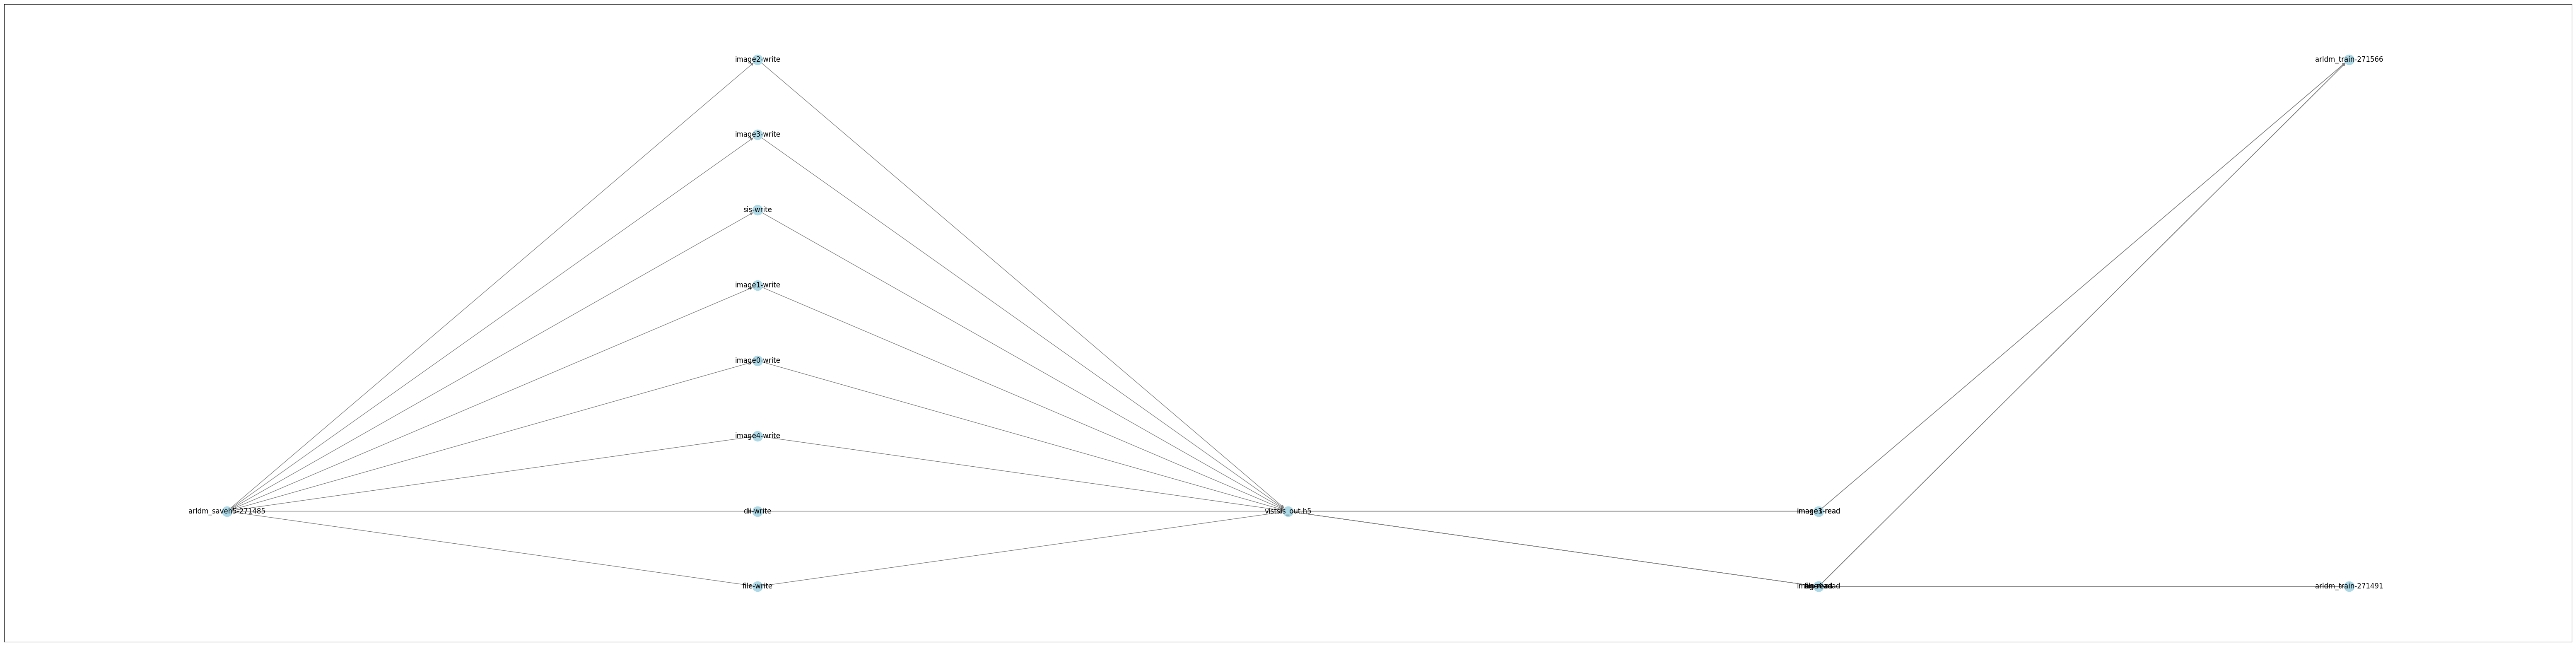

In [24]:
# sp.display_all_nodes_attr(G_VFD)
# G_VFD = vfd2g.set_file_position(G_VFD, task_file_map)
# sp.display_all_nodes_attr(G_VFD)

sp.draw_graph(G_VFD, test_name, stat_path, graph_type="vfd", prefix=f'{(STAGE_END+1)}s', save=True)

In [25]:
sp.display_all_edges_attr(G_VFD)

Edge: ('arldm_saveh5-271485', 'dii-write') - {'label': 'arldm_saveh5-271485', 'dset_stat': {'metadata': {'H5FD_MEM_OHDR': {'read_bytes': 512, 'read_cnt': 1, 'read_ranges': {'950': [0, 0]}, 'write_bytes': 0, 'write_cnt': 0, 'write_ranges': {}}}, 'data': {'H5FD_MEM_DRAW': {'read_bytes': 64, 'read_cnt': 4, 'read_ranges': {'260': [77, 77], '310': [77, 77], '850': [77, 77], '1170': [1946, 1946]}, 'write_bytes': 16, 'write_cnt': 1, 'write_ranges': {'730': [77, 77]}}}, 'order': 2}, 'access_type': 'read_write', 'stat': {'open_time': 1707802761002240, 'close_time': 1707802769427382, 'file_intent': ["'H5F_ACC_RDWR','H5F_ACC_TRUNC','H5F_ACC_CREAT'"], 'file_read_cnt': 41, 'file_write_cnt': 77, 'access_type': 'read_write', 'io_bytes': 13803096, 'file_size': 148078160}}
Edge: ('arldm_saveh5-271485', 'file-write') - {'label': 'arldm_saveh5-271485', 'dset_stat': {'metadata': {}, 'data': {'H5FD_MEM_DRAW': {'read_bytes': 0, 'read_cnt': 0, 'read_ranges': {}, 'write_bytes': 599544, 'write_cnt': 1, 'write_

# Add networkx to Sankey diagram

## Statistics for Sankey
Below are needed edge attributes before generating the sankey diagram:
- access_cnt : The total file/dataset access count 
- access_size : The total read and write access size
- operation : The operation type : read, write, read_write
- bandwidth : Get the per access size and time, then calculate the bandwidth. Average the bandwidth if multiple accesses. (TODO: currently only recording one access size and time)




In [26]:
def prepare_sankey_stat_full(G):
    all_edge_attr = G.edges()
    sankey_edge_attr = {}
    for edge, stat in all_edge_attr.items():
        all_dset_stat = stat['dset_stat']
        file_stat = stat['stat']
        
        data_access_bytes = 0
        data_access_cnt = 0
        metadata_access_bytes = 0
        metadata_access_cnt = 0
            
        # data access cnt        
        for dset, dstat in all_dset_stat.items():
            for meta_type in all_dset_stat['metadata']:
                meta_stat = all_dset_stat['metadata'][meta_type]
                metadata_access_bytes += meta_stat['read_bytes'] + meta_stat['write_bytes']
                metadata_access_cnt += meta_stat['read_cnt'] + meta_stat['write_cnt']
            for data_type in all_dset_stat['data']:
                data_stat = all_dset_stat['data'][data_type]
                data_access_bytes += data_stat['read_bytes'] + data_stat['write_bytes']
                data_access_cnt += data_stat['read_cnt'] + data_stat['write_cnt']        
        
        
        access_cnt = file_stat['file_read_cnt'] + file_stat['file_write_cnt']
        acesss_size = data_access_bytes + metadata_access_bytes        
        access_time_in_sec = (file_stat['close_time'] - file_stat['open_time'])/1000000
        bandwidth = acesss_size / access_time_in_sec
        position = G.nodes[edge[1]]['pos']
        
        edge_attr = {
                'position': position,
                'access_cnt': access_cnt,
                'access_size': acesss_size,
                'data_access_size': data_access_bytes,
                'data_access_cnt': data_access_cnt,
                'metadata_access_size': metadata_access_bytes,
                'metadata_access_cnt': metadata_access_cnt,
                'operation': stat['access_type'],
                'bandwidth': bandwidth}
        sankey_edge_attr[edge] = edge_attr
    
    nx.set_edge_attributes(G, sankey_edge_attr)
    
prepare_sankey_stat_full(G_VFD)

In [27]:
vfd2sk.time_to_file_x_pos(G_VFD)

All tasks:  ['arldm_saveh5-271485', 'arldm_train-271491', 'arldm_train-271566']
file-read New pos:  (5.0, 1)
image3-read New pos:  (5.25, 2)
sis-read New pos:  (5.0, 1)
image1-read New pos:  (5.25, 2)
image4-read New pos:  (5.5, 1)


In [31]:
vfd_nodes, vfd_nodes_dict = vfd2sk.get_nodes_for_sankey(G_VFD, label_on=True)

# print(vfd_nodes)

vfd_links = vfd2sk.get_links_for_sankey(G_VFD, vfd_nodes_dict, val_sqrt=False)
fig = go.Figure(go.Sankey(
            node = vfd_nodes,
            link = vfd_links, orientation='h'))

width = 2000
height = 800

fig.update_layout(
    autosize=False,
    width=width,
    height=height,
    margin=dict(
        l=width/100,
        r=width/100,
        b=height/10,
        t=height/5,
        pad=2
    ),
    font=dict(size=18),
)


fig.show()
save_html_path = f"{stat_path}/vfd-{(STAGE_END+1)}s-{test_name}-sankey-labeled-s4.html"
fig.write_html(save_html_path)
print(f"Sankey saved to {save_html_path}")

bandwidth range: 85.46 B/s ~ 15.14 MB/s


Sankey saved to example_stat/vist/vfd-2s-vist-sankey-labeled-s4.html


In [29]:
stat_str = sp.show_vfd_stats(G_VFD)
print(stat_str)



Total number of links: 27
Total I/O size: 86.54 MB
Total I/O count: 1926
Total bandwidth: 41.18 MB/s
Average I/O size: 44.93 KB
Medium I/O size: 12.29 KB
Inital input size: 0



In [30]:
# Create a manual legend using annotations.

def add_legend_to_graph(fig,save_img=False):
    LEGEND_ITEMS = {
        "Tasks":{"color":"red", "text":"Tasks"},
        "Files":{"color":"blue", "text":"Files"},
        "Edges":{"color":"lightblue", "text":"File bandwidth, darker the color, higher the bandwidth"},
    }

    legend_items = [
        go.layout.Annotation(
            x=0.9,  # X-coordinate for legend item
            y=0.85 - i * 0.03,  # Y-coordinate for legend item (adjust for position)
            xref='paper',
            yref='paper',
            text=f"{item_type} - {LEGEND_ITEMS[item_type]['color']}",
            showarrow=False,
            font=dict(size=14, color=LEGEND_ITEMS[item_type]['color']),
            # bordercolor='grey',  # Set the border color for the legend box
            # borderwidth=1,  # Set the border width for the legend box
            bgcolor='rgba(255, 255, 255, 0.7)',  # Add a transparent background color
        )
        for i, item_type in enumerate(LEGEND_ITEMS.keys())
    ]
    fig.update_layout(annotations=legend_items)
    fig.show()
    if save_img:
        fig.write_html(f"{stat_path}/vfd-{(STAGE_END+1)}s-{test_name}-sankey-annotated.html")
